安装vscode jupyter toolkit，运行Group 1

# 任务模型

<img src='taskModel.png'/>

## 建模主要参数
- 任务id——task_id
- 任务到达时间——task_arrival_time
- 任务截止时间——task_deadline
- 任务接收处理时长——task_receive_time_span
- 任务接收处理CPU占用率——task_receive_CPU_utilization
- 任务计算时长——tack_computing_time_span
- 任务计算处理CPU占用率——task_process_CPU_utilization

# 任务到达poisson过程

poisson主要描述在给定时间间隔内发生k次事件的概率

如果给定随机变量X服从poisson分布，X恰好等于k次的公式为：
$$P(X=k) = {\lambda ^k / k!} * e^{-\lambda}$$

- $\lambda$：给定时间内发生事件均值
- $k$：发生事件的次数
- $e$:常量,近似等于2.71828

poisson分布需要满足一下条件：
- 事件发生次数可数
- 在给定时间发生次数的均值已知
- 每个结果独立
- 发生概率与时间间隔成比例

##  模型假设

在本任务模型的例子中，可以将任务的到达看成是一个poisson过程：
- 次数可以计算——可以计算出任务的到达量（整数）
- 特定的时间间隔内，任务到达的平均次数可以统计得知
- 结果互相独立——假设任务的到达互相独立，不影响
- 成功发生的概率与时间间隔的大小成正比——间隔的时间越长，任务到达的概率越高

模型假设：
- 任务的到达互相独立
- 最小时间间隔为$\Delta t$，生成离散的时间序列
- 任务到达的时间是$\Delta t$的整数倍

## 相关代码

In [131]:
import math
import numpy as np
from itertools import accumulate
import matplotlib.pyplot as plt
from scipy.stats import poisson
import pandas as pd
import plotly.figure_factory as ff
import plotly.express as px
from matplotlib import cm
#注意不要把Python内置的random和np.random搞混了

#在三份代码运行之前，需要确认读取的文件名和参数是不是对的
SIZE=10000
LAM=50 #平均每秒到达10个
MU=12 #平均每秒计算完成12个
PHI=20 #接收的时候，平均每秒接收完14个
NORMAL_MEAN_RATE= 2.0
NORMAL_VAR_RATE=0.1
task_head:str=f'LAM{LAM}_MU{MU}_'

可能传输的数据大小（对应接收时长）、CPU占用率和CPU计算时长有一定关系，但是比较复杂，在此不考虑

In [132]:
class Task():
  def __init__(self,task_id,task_arrival_time,task_deadline,task_receive_time_span,task_receive_CPU_utilization,tack_process_time_span,task_process_CPU_utilization):
    self.task_id = task_id
    self.task_arrival_time = task_arrival_time
    self.task_deadline = task_deadline
    self.task_receive_time_span = task_receive_time_span
    self.task_receive_CPU_utilization = task_receive_CPU_utilization
    self.tack_process_time_span = tack_process_time_span
    self.task_process_CPU_utilization = task_process_CPU_utilization
  def __str__(self):
    #print task info 
    return "task id: %d task_arrival_time :%d  task_deadline: %d task_receive_time_span:%d  task_receive_CPU_utilization: %d tack_process_time_span: %d task_process_CPU_utilization: %d"  \
      % (self.task_id, self.task_arrival_time,self.task_deadline,self.task_receive_time_span, self.task_receive_CPU_utilization,self.tack_process_time_span,self.task_process_CPU_utilization)
  
  def get_task_id(self):
    # get task id 
    return self.task_id

In [133]:
# 先仿真出时间，使用反变换法仿真出时间间隔并计算时刻，到点停止


# def simulate_integer_negative_exponential(rate, size)->np.ndarray:
#     uniform_samples = np.random.random(size)
#     exponential_samples = -1 / rate * np.log(1 - uniform_samples)
#     integer_samples = np.round(exponential_samples).astype(int)#取整
#     return integer_samples

# 生成整数负指数分布随机数
# time_interval:np.ndarray = simulate_integer_negative_exponential(lam, size)

# # 打印生成的随机数
# print(time_interval)

#每十分钟2个人，每分钟0.2个人，lambda=0.2，scale=5=均值
# time_interval=np.round(np.random.exponential(scale=1/lam,size=size))
time_interval=np.random.exponential(scale=1/LAM,size=SIZE)
# time_interval=time_interval.astype("int")
print(type(time_interval))
time_interval=time_interval.tolist()


task_arrival_time=list(accumulate(time_interval))

# 统计不同时间段内的任务数

<class 'numpy.ndarray'>


# 任务处理时间

- 由于来的任务是随机的，认为任务接收的CPU占用率随机分布（10为步进）
- 假设接受的整个过程持续时间很短，范围在1-3个index
- 任务处理的时间满足指数分布（取整）
- 任务处理时候CPU占用率随机分布（10为步进）

In [134]:
task_receive_time_span:np.ndarray= np.random.exponential(scale=1/PHI,size=SIZE)#接收时长
task_computing_time_span:np.ndarray=np.random.exponential(scale=1/MU,size=SIZE)#计算时长
task_process_time_span=task_receive_time_span+task_computing_time_span
task_normal_mean=task_process_time_span*NORMAL_MEAN_RATE
task_normal_var=task_process_time_span*NORMAL_VAR_RATE
task_max_wait_time_span=np.empty(shape=SIZE)
for index,min_wait_time in enumerate(task_process_time_span):
    while True:
        random_wait_time:np.ndarray=np.random.normal(loc=task_normal_mean[index],scale=task_normal_var[index],size=1)
        random_wait_time=float(random_wait_time[0])#因为只有一个元素，所以可以这样操作
        if random_wait_time>min_wait_time:
            task_max_wait_time_span[index]=random_wait_time
            break
task_receive_time_span=task_receive_time_span.tolist()
task_computing_time_span=task_computing_time_span.tolist()
task_process_time_span=task_process_time_span.tolist()

print(task_process_time_span)
print(task_max_wait_time_span)


[0.1133999717149336, 0.14710516823695374, 0.09112824835443137, 0.2411480135770994, 0.22329825257990626, 0.14991123874898132, 0.08030371291057757, 0.07196196266642983, 0.07705640337345639, 0.15497592671272323, 0.18977498837747045, 0.08190420314332594, 0.06615541736378769, 0.2844860819336285, 0.2906899505946505, 0.2122616321221121, 0.20526032171583425, 0.10434791548753111, 0.04563489313711736, 0.15502185063696078, 0.06301158194324329, 0.22876353470707259, 0.09235045967086224, 0.22256292637728944, 0.10739339508603854, 0.14901756408046155, 0.1041380071045189, 0.1270438907423772, 0.24336943507484735, 0.4842808579253396, 0.17786632034894984, 0.10219523486202303, 0.031528673325171064, 0.19383855824376472, 0.09518439215222121, 0.07860696189050381, 0.36973103686783065, 0.29627786610842405, 0.11826754503104231, 0.2498310910385811, 0.1414429602560378, 0.022646872256835975, 0.31516524449270866, 0.008749718537610755, 0.07878477271689094, 0.17557540170084146, 0.10340274462090823, 0.21170263515750892

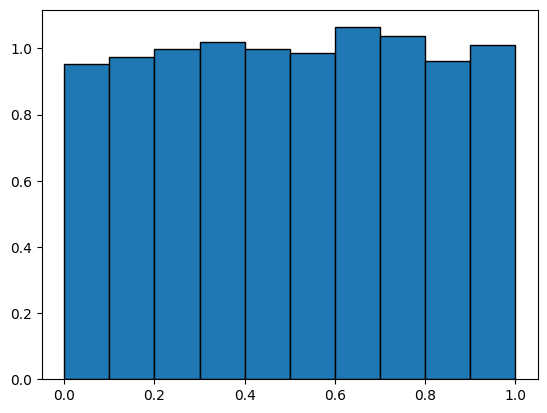

In [135]:
task_CPU_utilization=np.random.uniform(low=0,high=1,size=SIZE)
plt.hist(task_CPU_utilization, density=True, edgecolor='black')
plt.show()

In [136]:
print(type(task_process_time_span))

<class 'list'>


In [137]:
df = pd.DataFrame(columns=('Task_ID',
                           'Arrival_time',
                           'Receive_time_span',
                           'Start_computing_time',
                           'Process_time_span',
                           'Finish',
                           'Max_wait_time_span',
                           'DeadLine',
                           'Cpu_utilization'))

df['Task_ID'] = range(len(task_arrival_time))
df['Arrival_time'] =  task_arrival_time
df['Receive_time_span'] = task_receive_time_span#暂未使用
df['Start_computing_time'] = [x+y for x, y in zip(task_arrival_time,task_receive_time_span)]#暂未使用
df['Process_time_span'] = task_process_time_span
df['Finish'] = [x+y for x, y in zip(task_arrival_time,task_process_time_span)]
df['Max_wait_time_span']=task_max_wait_time_span
df['DeadLine']=[x+y+z for x,y,z in zip(task_arrival_time,task_max_wait_time_span,task_process_time_span)]
df['Cpu_utilization'] = task_CPU_utilization

df.to_json(f'{task_head}20230712TaskMatrix.json')



In [138]:

mydf = pd.DataFrame(columns=('Task','Start','Finish'))
mydf['Start'] = task_arrival_time
mydf['Finish'] = [x+y for x, y in zip(task_arrival_time,task_receive_time_span)]
# mydf['Finish'] = [x+y for x, y in zip(task_arrival_time,task_process_time_span)]
mydf['Task'] = range(len(task_arrival_time))

datetime = pd.Timestamp('20190627 19:00:00')
for i in range(len(mydf)):#更改时间起点
    mydf['Start'].loc[i] = datetime + pd.Timedelta(seconds = mydf['Start'].loc[i])
    mydf['Finish'].loc[i] = datetime + pd.Timedelta(seconds = mydf['Finish'].loc[i])
mydf['Resource'] = np.random.randint(10,20,len(task_arrival_time))#是用来做什么的呢
    
mydf.head()
color = ['#000ff','#1e90ff','#6495ed','#00bff','#87cefa','#add8e6','#b0e0e6','#afeeee','#e0ffff','#00ffff']

fig = ff.create_gantt(mydf[0:10], colors=color,
                      show_colorbar=True, bar_width=0.5, showgrid_x=True, showgrid_y=True)
fig.show()


In [139]:
datetime = pd.Timestamp('20190627 19:00:00')
for i in range(len(df)):
    df['Arrival_time'].loc[i] = datetime + pd.Timedelta(seconds = df['Arrival_time'].loc[i])
    df['Start_computing_time'].loc[i] = datetime + pd.Timedelta(seconds = df['Start_computing_time'].loc[i])
    df['Finish'].loc[i] = datetime + pd.Timedelta(seconds = df['Finish'].loc[i])
# fig = px.timeline(df[0:10],x_start='Arrival_time',x_end='Start_computing_time',y='Task_ID')
fig = px.timeline(df[0:10],x_start='Arrival_time',x_end='Finish',y='Task_ID')
fig.show()

C:\Users\LAPTOP_Lin-uCong\AppData\Local\Temp\ipykernel_21580\2336182416.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\LAPTOP_Lin-uCong\AppData\Local\Temp\ipykernel_21580\2336182416.py:14: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



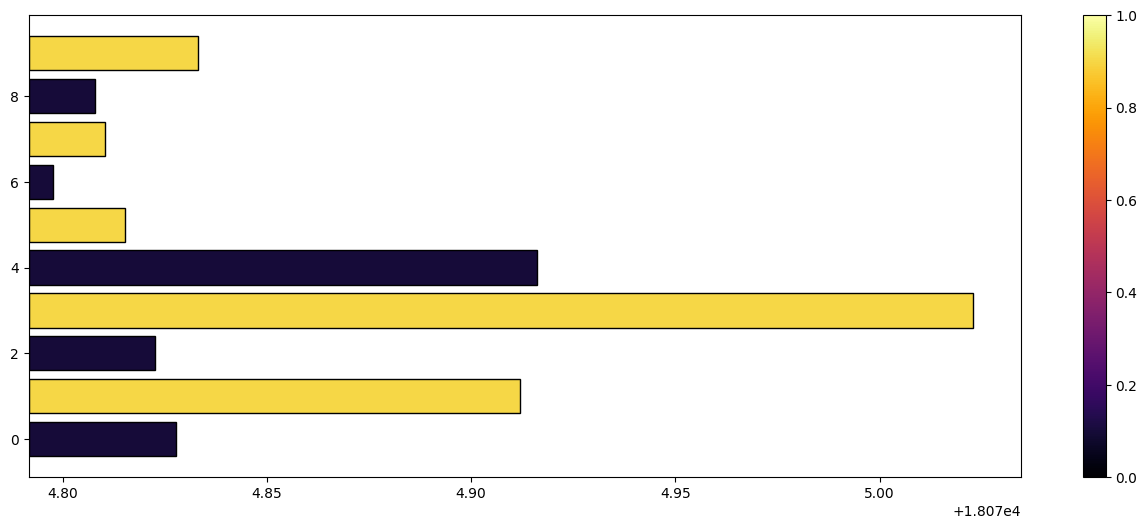

In [140]:
fig, ax = plt.subplots(1, figsize=(16,6))# 这行代码创建了一个新的Figure对象和一个Axes对象。Figure对象代表整个图形窗口，而Axes对象代表具体的绘图区域。通过subplots()函数可以同时创建Figure和Axes对象，并将Axes对象赋值给ax变量。
norm = plt.Normalize(0,1)# 这行代码创建了一个归一化对象norm，用于将数值范围映射到0到1之间的范围。
key_values = [0.1,0.9] #  这行代码定义了一组关键值，用于在颜色映射中确定颜色的取值范围。
norm_values = norm(key_values)# 这行代码使用归一化对象norm将关键值映射到0到1之间的范围。
map_vir = cm.get_cmap(name='inferno')# 这行代码获取了名为'inferno'的颜色映射对象，用于将归一化后的值映射到颜色空间。
colors = map_vir(norm_values)#  这行代码将归一化后的值应用于颜色映射对象，得到一组对应的颜色。

# 这行代码创建了水平条形图。df[0:10]是一个DataFrame对象，它选择了前10行的特定列作为数据。
# Task_ID是条形图的y轴，Receive_time_span是条形图的宽度，Arrival_time是条形图的起点，colors确定了条形图的颜色，edgecolor指定了条形图的边框颜色。
ax.barh(df[0:10].Task_ID, df[0:10].Receive_time_span, left=df[0:10].Arrival_time,color=colors,edgecolor='black')
# ax.barh(df[0:10].Task_ID,  df[0:10].Start_computing_time,left = df[0:10].Start_computing_time,color=colors,edgecolor='black')
sm = cm.ScalarMappable(cmap=map_vir,norm=norm)  # norm设置最大最小值 # 这行代码创建了一个ScalarMappable对象sm，用于创建颜色映射的图例。cmap参数指定了颜色映射对象，norm参数指定了归一化对象。
sm.set_array([])# 这行代码设置了sm对象的数组为空。这样做是为了确保图例显示正确的颜色映射范围。
plt.colorbar(sm)# 这行代码添加了一个颜色图例，显示颜色映射的范围。

plt.show()